In [1]:
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
import seaborn as sns
from sklearn.decomposition import PCA

# Compute silhouette scores
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples,
    silhouette_score,
)

sys.path.append("../")

from src.analytics.static_analysis import (
    get_cluster_colors,
    get_cluster_markers,
    get_marker_size_corrections,
    get_size_categories,
    interpret_cluster_from_data,
)
from src.plots.maps import russia_plots
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
log = setup_logger("chapter_one", log_file="../logs/chapter_one.log")

ws, gauges = load_geodata(folder_depth="../")
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
common_index = gauges.index.to_list()

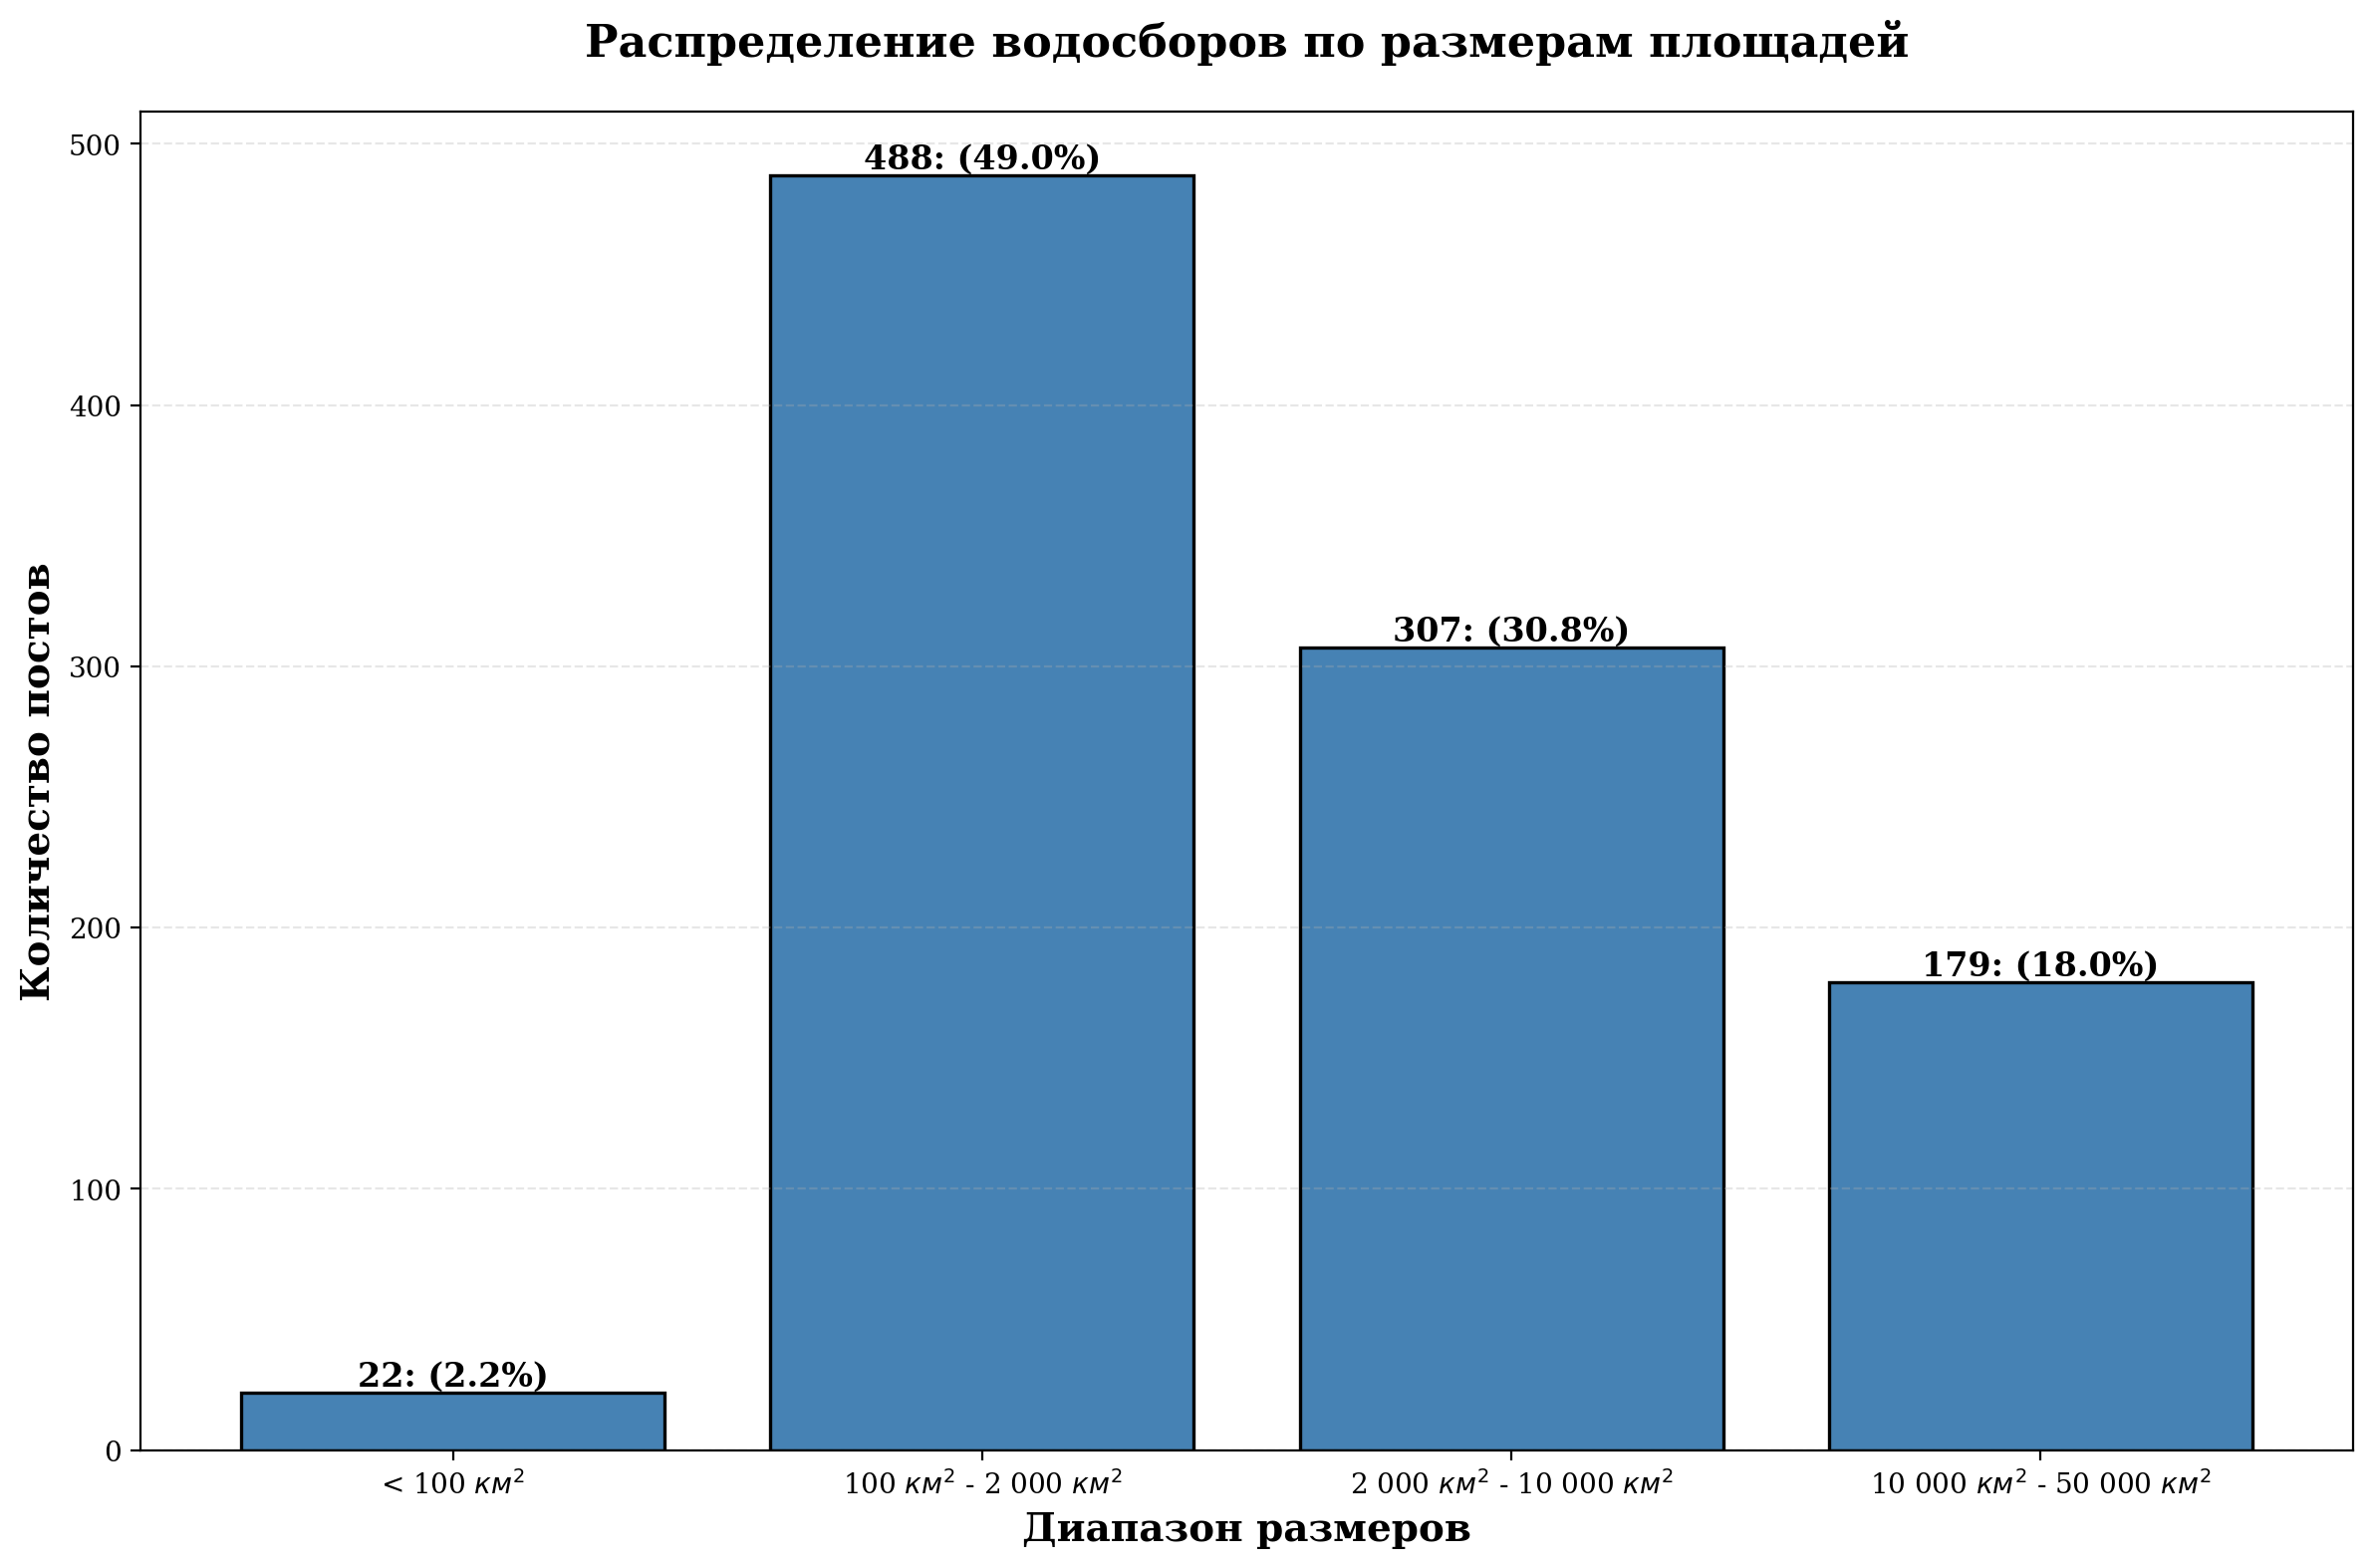

2025-10-21 00:26:00 | INFO     | PhDLogger | chapter_one | ℹ️  Watershed size distribution analysis complete


In [2]:
# Compute statistics
size_counts = ws["size"].value_counts(sort=False).sort_index()
total_gauges = len(ws)

# Create summary DataFrame
size_summary = pd.DataFrame(
    {
        "Size Category": size_counts.index,
        "Count": size_counts.values,
        "Percentage": (size_counts.values / total_gauges * 100).round(2),
    }
)

# Calculate area statistics per category
area_stats = []
for cat in get_size_categories():
    cat_data = ws[ws["size"] == cat]["area_km2"]
    area_stats.append(
        {
            "Category": cat,
            "Min (km²)": cat_data.min(),
            "Mean (km²)": cat_data.mean(),
            "Median (km²)": cat_data.median(),
            "Max (km²)": cat_data.max(),
        }
    )
area_stats_df = pd.DataFrame(area_stats)


# Plot distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(
    range(len(size_counts)),
    size_counts.values,
    color="steelblue",
    edgecolor="black",
    linewidth=1.2,
)
ax.set_xticks(range(len(size_counts)))
ax.set_xticklabels(
    [cat.split(") ")[1] for cat in size_counts.index], rotation=0, ha="center"
)
ax.set_xlabel("Диапазон размеров", fontsize=14, fontweight="bold")
ax.set_ylabel("Количество постов", fontsize=14, fontweight="bold")
ax.set_title(
    "Распределение водосборов по размерам площадей",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
ax.grid(axis="y", alpha=0.3, linestyle="--")

# Add value labels
for rect, cnt in zip(bars, size_counts.values, strict=False):
    pct = cnt / total_gauges * 100
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        f"{cnt}: ({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

fig.tight_layout()
fig.savefig("../res/images/watershed_size_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

log.info("Watershed size distribution analysis complete")


In [3]:
# Load HydroATLAS data
geo_data = pd.read_csv(
    "../data/attributes/hydro_atlas_cis_camels.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
static_parameters = [
    "for_pc_use",
    "crp_pc_use",
    "inu_pc_ult",
    "ire_pc_use",
    "lka_pc_use",
    "prm_pc_use",
    "pst_pc_use",
    "cly_pc_uav",
    "slt_pc_uav",
    "snd_pc_uav",
    "kar_pc_use",
    "urb_pc_use",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "slp_dg_uav",
    "sgr_dk_sav",
    "ws_area",
    "ele_mt_uav",
]
geo_subset = geo_data.loc[common_index, static_parameters]

# Scale to 0-1 range
geo_scaled = (geo_subset - geo_subset.min()) / (geo_subset.max() - geo_subset.min())

available_features = geo_scaled.loc[:, static_parameters].columns


In [4]:
log.info(f"Selected {len(available_features)} HydroATLAS features")
print(f"Features: {list(available_features)}")

feature_descriptions = {
    "for_pc_use": {
        "name": "Forest Cover",
        "description": "Percentage of forest area within the upstream watershed extent",
        "suffix": "use",
        "category": "Land Cover & Vegetation",
        "hydrological_impact": "Controls evapotranspiration rates through canopy interception and transpiration. Moderates peak flows by increasing infiltration and soil water storage. Reduces surface runoff generation and sediment transport. Critical for baseflow maintenance during dry periods.",
        "units": "%",
        "source": "GLC2000, GlobCover",
    },
    "crp_pc_use": {
        "name": "Cropland Extent",
        "description": "Percentage of agricultural cropland within the upstream watershed extent",
        "suffix": "use",
        "category": "Land Cover & Human Impact",
        "hydrological_impact": "Introduces seasonal hydrological variability tied to agricultural cycles. Increases surface runoff due to soil compaction and reduced vegetation cover. May alter natural flow regimes through irrigation water extraction. Affects nutrient and sediment transport patterns.",
        "units": "%",
        "source": "GLC2000, GlobCover",
    },
    "inu_pc_ult": {
        "name": "Inundation-Prone Areas",
        "description": "Percentage of areas susceptible to inundation within the total upstream watershed",
        "suffix": "ult",
        "category": "Flood & Water Regulation",
        "hydrological_impact": "Indicates natural flood storage capacity and wetland presence. Attenuates flood peaks through temporary water storage. Reduces flow variability and provides ecological buffer zones. Critical for understanding watershed flood risk and water regulation services.",
        "units": "%",
        "source": "GIEMS, MODIS",
    },
    "ire_pc_use": {
        "name": "Irrigated Area",
        "description": "Percentage of irrigated agricultural land within the upstream watershed extent",
        "suffix": "use",
        "category": "Land Cover & Human Impact",
        "hydrological_impact": "Directly reduces streamflow through water abstraction for irrigation. Alters natural flow regime and seasonal discharge patterns. May increase return flows and groundwater recharge in some areas. Critical indicator of anthropogenic water stress.",
        "units": "%",
        "source": "GMIA, FAO",
    },
    "lka_pc_use": {
        "name": "Lake Coverage",
        "description": "Percentage of lake area within the upstream watershed extent",
        "suffix": "use",
        "category": "Hydrology & Water Storage",
        "hydrological_impact": "Provides natural flow regulation and dampens hydrological variability. Delays hydrological response to precipitation events. Increases evaporation losses and modifies water temperature. Critical for understanding flow attenuation and storage capacity.",
        "units": "%",
        "source": "HydroLAKES, GLWD",
    },
    "prm_pc_use": {
        "name": "Permafrost Extent",
        "description": "Percentage of permafrost area within the upstream watershed extent",
        "suffix": "use",
        "category": "Cryosphere & Soil Properties",
        "hydrological_impact": "Severely restricts soil infiltration capacity, leading to high surface runoff. Creates extreme seasonal discharge patterns with minimal winter flow. Highly sensitive to climate warming with potential for regime shifts. Controls subsurface flow pathways and groundwater recharge.",
        "units": "%",
        "source": "NSIDC",
    },
    "pst_pc_use": {
        "name": "Pasture Coverage",
        "description": "Percentage of pasture and grazing land within the upstream watershed extent",
        "suffix": "use",
        "category": "Land Cover & Human Impact",
        "hydrological_impact": "Moderate infiltration capacity between forest and cropland. Grazing pressure may cause soil compaction affecting runoff generation. Less seasonal variability compared to cropland. Affects sediment yield and water quality through livestock impacts.",
        "units": "%",
        "source": "GLC2000, GlobCover",
    },
    "cly_pc_uav": {
        "name": "Clay Content",
        "description": "Percentage of clay in topsoil, area-weighted average across the upstream watershed",
        "suffix": "uav",
        "category": "Soil Properties",
        "hydrological_impact": "Low hydraulic conductivity restricts infiltration and promotes surface runoff. High water retention capacity but limited drainage. Increases flood risk during intense precipitation. Controls soil moisture dynamics and groundwater recharge potential.",
        "units": "%",
        "source": "SoilGrids, HWSD",
    },
    "slt_pc_uav": {
        "name": "Silt Content",
        "description": "Percentage of silt in topsoil, area-weighted average across the upstream watershed",
        "suffix": "uav",
        "category": "Soil Properties",
        "hydrological_impact": "Moderate infiltration and water-holding capacity between clay and sand. High susceptibility to erosion and sediment transport. Influences soil crusting which affects runoff generation. Critical for understanding sediment dynamics and water quality.",
        "units": "%",
        "source": "SoilGrids, HWSD",
    },
    "snd_pc_uav": {
        "name": "Sand Content",
        "description": "Percentage of sand in topsoil, area-weighted average across the upstream watershed",
        "suffix": "uav",
        "category": "Soil Properties",
        "hydrological_impact": "High hydraulic conductivity promotes rapid infiltration and groundwater recharge. Low water retention leads to reduced surface runoff but also lower soil moisture availability. Favors baseflow-dominated discharge regimes. Critical for aquifer recharge assessment.",
        "units": "%",
        "source": "SoilGrids, HWSD",
    },
    "kar_pc_use": {
        "name": "Karst Area",
        "description": "Percentage of karst terrain within the upstream watershed extent",
        "suffix": "use",
        "category": "Hydrogeology & Baseflow",
        "hydrological_impact": "Subsurface flow dominates over surface runoff through dissolution features. Spring-fed baseflow provides stable discharge during dry periods. Complex groundwater-surface water interactions. May exhibit losing/gaining stream reaches and high spatial flow variability.",
        "units": "%",
        "source": "WOKAM, GLHYMPS",
    },
    "urb_pc_use": {
        "name": "Urban Area",
        "description": "Percentage of urban and built-up area within the upstream watershed extent",
        "suffix": "use",
        "category": "Land Cover & Human Impact",
        "hydrological_impact": "Impervious surfaces generate rapid runoff and flashy hydrographs. Dramatically reduces infiltration and groundwater recharge. Increases flood peaks and decreases baseflow. Critical indicator of hydrological regime alteration and water quality degradation.",
        "units": "%",
        "source": "GLC2000, MODIS",
    },
    "gwt_cm_uav": {
        "name": "Groundwater Table Depth",
        "description": "Depth to groundwater table in centimeters, sub-basin area-weighted average",
        "suffix": "uav",
        "category": "Hydrogeology & Baseflow",
        "hydrological_impact": "Shallow water tables enhance baseflow contribution and maintain perennial flow. Deep water tables limit groundwater-surface water exchange. Controls riparian vegetation and wetland distribution. Critical for understanding drought resilience and low-flow characteristics.",
        "units": "cm",
        "source": "Fan et al. 2013",
    },
    "lkv_mc_usu": {
        "name": "Lake Volume",
        "description": "Total volume of lakes within the upstream watershed, summed upstream",
        "suffix": "usu",
        "category": "Hydrology & Water Storage",
        "hydrological_impact": "Quantifies total natural storage capacity affecting flow regulation. Large volumes dampen seasonal variability and moderate extreme events. Increases residence time and evaporation losses. Critical for understanding watershed buffering capacity and drought resilience.",
        "units": "million m³",
        "source": "HydroLAKES",
    },
    "rev_mc_usu": {
        "name": "Reservoir Volume",
        "description": "Total volume of reservoirs within the upstream watershed, summed upstream",
        "suffix": "usu",
        "category": "Hydrology & Anthropogenic Impact",
        "hydrological_impact": "Represents artificial flow regulation capacity through dam operations. Modifies natural flow regime according to management objectives. Reduces peak flows and increases low flows depending on operation rules. Critical for understanding anthropogenic hydrological alteration.",
        "units": "million m³",
        "source": "GRanD, HydroLAKES",
    },
    "slp_dg_uav": {
        "name": "Terrain Slope",
        "description": "Mean terrain slope in degrees, area-weighted average across the upstream watershed",
        "suffix": "uav",
        "category": "Topography & Physiography",
        "hydrological_impact": "Steep slopes accelerate runoff generation and reduce infiltration time. Controls flow velocity and time of concentration. Increases erosion potential and sediment transport. Critical for understanding flashiness and flood response timing.",
        "units": "degrees",
        "source": "SRTM, HydroSHEDS",
    },
    "sgr_dk_uav": {
        "name": "Stream Gradient",
        "description": "Stream channel gradient in decimal form, sub-basin area-weighted average",
        "suffix": "uav",
        "category": "Topography & River Morphology",
        "hydrological_impact": "Controls flow velocity and energy dissipation in the channel network. Steep gradients increase transport capacity for sediment and debris. Affects channel erosion, deposition patterns, and habitat structure. Critical for understanding hydraulic characteristics and geomorphic processes.",
        "units": "decimal",
        "source": "HydroSHEDS",
    },
    "ws_area": {
        "name": "Watershed Area",
        "description": "Total drainage area of the watershed",
        "suffix": "n/a",
        "category": "Topography & Physiography",
        "hydrological_impact": "Fundamental control on discharge magnitude and hydrological response. Larger watersheds exhibit dampened, delayed responses and higher baseflow contributions. Controls scaling relationships for flood peaks and low flows. Essential for understanding discharge regime and comparative hydrology.",
        "units": "km²",
        "source": "HydroSHEDS",
    },
    "ele_mt_uav": {
        "name": "Mean Elevation",
        "description": "Mean elevation in meters above sea level, area-weighted average across the upstream watershed",
        "suffix": "uav",
        "category": "Topography & Climate",
        "hydrological_impact": "Controls precipitation amount through orographic enhancement. Determines snowmelt versus rainfall-dominated regimes. Affects temperature, evapotranspiration rates, and vegetation zones. Critical for understanding vertical climate gradients and seasonal discharge patterns.",
        "units": "m",
        "source": "SRTM, HydroSHEDS",
    },
}
russian_names = {
    "for_pc_use": "Лесистость",
    "crp_pc_use": "Пахотные земли",
    "inu_pc_ult": "Затапливаемые территории",
    "ire_pc_use": "Орошаемые территории",
    "lka_pc_use": "Озерность",
    "prm_pc_use": "Мерзлотные территории",
    "pst_pc_use": "Пастбища",
    "cly_pc_uav": "Глинистость",
    "slt_pc_uav": "Осадочные породы",
    "snd_pc_uav": "Песчаные породы",
    "kar_pc_use": "Карстовые породы",
    "urb_pc_use": "Урбанизированные территории",
    "gwt_cm_uav": "Глубина первого водоносного горизонта",
    "slp_dg_uav": "Средний уклон водосбора",
    "sgr_dk_uav": "Средний уклон речной сети",
    "lkv_mc_usu": "Объём озёр",
    "rev_mc_usu": "Объём водохранилищ",
    "ws_area": "Площадь водосбора",
    "ele_mt_uav": "Средняя высота водосбора",
}
# Create DataFrame for display
feature_df = pd.DataFrame.from_dict(feature_descriptions, orient="index")
feature_df.index.name = "HydroATLAS Code"
feature_df = feature_df.reset_index()

# Reorder columns
feature_df = feature_df[
    [
        "HydroATLAS Code",
        "name",
        "description",
        "suffix",
        "units",
        "category",
        "hydrological_impact",
        "source",
    ]
]

# Rename columns for clarity
feature_df.columns = [
    "HydroATLAS Code",
    "Short Name",
    "Full Description",
    "Suffix",
    "Units",
    "Category",
    "Hydrological Impact",
    "Data Source",
]

feature_df


2025-10-21 00:26:00 | INFO     | PhDLogger | chapter_one | ℹ️  Selected 19 HydroATLAS features


Features: ['for_pc_use', 'crp_pc_use', 'inu_pc_ult', 'ire_pc_use', 'lka_pc_use', 'prm_pc_use', 'pst_pc_use', 'cly_pc_uav', 'slt_pc_uav', 'snd_pc_uav', 'kar_pc_use', 'urb_pc_use', 'gwt_cm_sav', 'lkv_mc_usu', 'rev_mc_usu', 'slp_dg_uav', 'sgr_dk_sav', 'ws_area', 'ele_mt_uav']


HydroATLAS Code               Short Name  \
0       for_pc_use             Forest Cover   
1       crp_pc_use          Cropland Extent   
2       inu_pc_ult   Inundation-Prone Areas   
3       ire_pc_use           Irrigated Area   
4       lka_pc_use            Lake Coverage   
5       prm_pc_use        Permafrost Extent   
6       pst_pc_use         Pasture Coverage   
7       cly_pc_uav             Clay Content   
8       slt_pc_uav             Silt Content   
9       snd_pc_uav             Sand Content   
10      kar_pc_use               Karst Area   
11      urb_pc_use               Urban Area   
12      gwt_cm_uav  Groundwater Table Depth   
13      lkv_mc_usu              Lake Volume   
14      rev_mc_usu         Reservoir Volume   
15      slp_dg_uav            Terrain Slope   
16      sgr_dk_uav          Stream Gradient   
17         ws_area           Watershed Area   
18      ele_mt_uav           Mean Elevation   

                                     Full Description Suffix       Units  \
0   Percentage of forest area within the upstream ...    use           %   
1   Percentage of agricultural cropland within the...    use           %   
2   Percentage of areas susceptible to inundation ...    ult           %   
3   Percentage of irrigated agricultural land with...    use           %   
4   Percentage of lake area within the upstream wa...    use           %   
5   Percentage of permafrost area within the upstr...    use           %   
6   Percentage of pasture and grazing land within ...    use           %   
7   Percentage of clay in topsoil, area-weighted a...    uav           %   
8   Percentage of silt in topsoil, area-weighted a...    uav           %   
9   Percentage of sand in topsoil, area-weighted a...    uav           %   
10  Percentage of karst terrain within the upstrea...    use           %   
11  Percentage of urban and built-up area within t...    use           %   
12  Depth to groundwater table in centimeters, sub...    uav          cm   
13  Total volume of lakes within the upstream wate...    usu  million m³   
14  Total volume of reservoirs within the upstream...    usu  million m³   
15  Mean terrain slope in degrees, area-weighted a...    uav     degrees   
16  Stream channel gradient in decimal form, sub-b...    uav     decimal   
17               Total drainage area of the watershed    n/a         km²   
18  Mean elevation in meters above sea level, area...    uav           m   

                            Category  \
0            Land Cover & Vegetation   
1          Land Cover & Human Impact   
2           Flood & Water Regulation   
3          Land Cover & Human Impact   
4          Hydrology & Water Storage   
5       Cryosphere & Soil Properties   
6          Land Cover & Human Impact   
7                    Soil Properties   
8                    Soil Properties   
9                    Soil Properties   
10           Hydrogeology & Baseflow   
11         Land Cover & Human Impact   
12           Hydrogeology & Baseflow   
13         Hydrology & Water Storage   
14  Hydrology & Anthropogenic Impact   
15         Topography & Physiography   
16     Topography & River Morphology   
17         Topography & Physiography   
18              Topography & Climate   

                                  Hydrological Impact         Data Source  
0   Controls evapotranspiration rates through cano...  GLC2000, GlobCover  
1   Introduces seasonal hydrological variability t...  GLC2000, GlobCover  
2   Indicates natural flood storage capacity and w...        GIEMS, MODIS  
3   Directly reduces streamflow through water abst...           GMIA, FAO  
4   Provides natural flow regulation and dampens h...    HydroLAKES, GLWD  
5   Severely restricts soil infiltration capacity,...               NSIDC  
6   Moderate infiltration capacity between forest ...  GLC2000, GlobCover  
7   Low hydraulic conductivity restricts infiltrat...     SoilGrids, HWSD  
8   Moderate infiltration and water-holding capaci...   

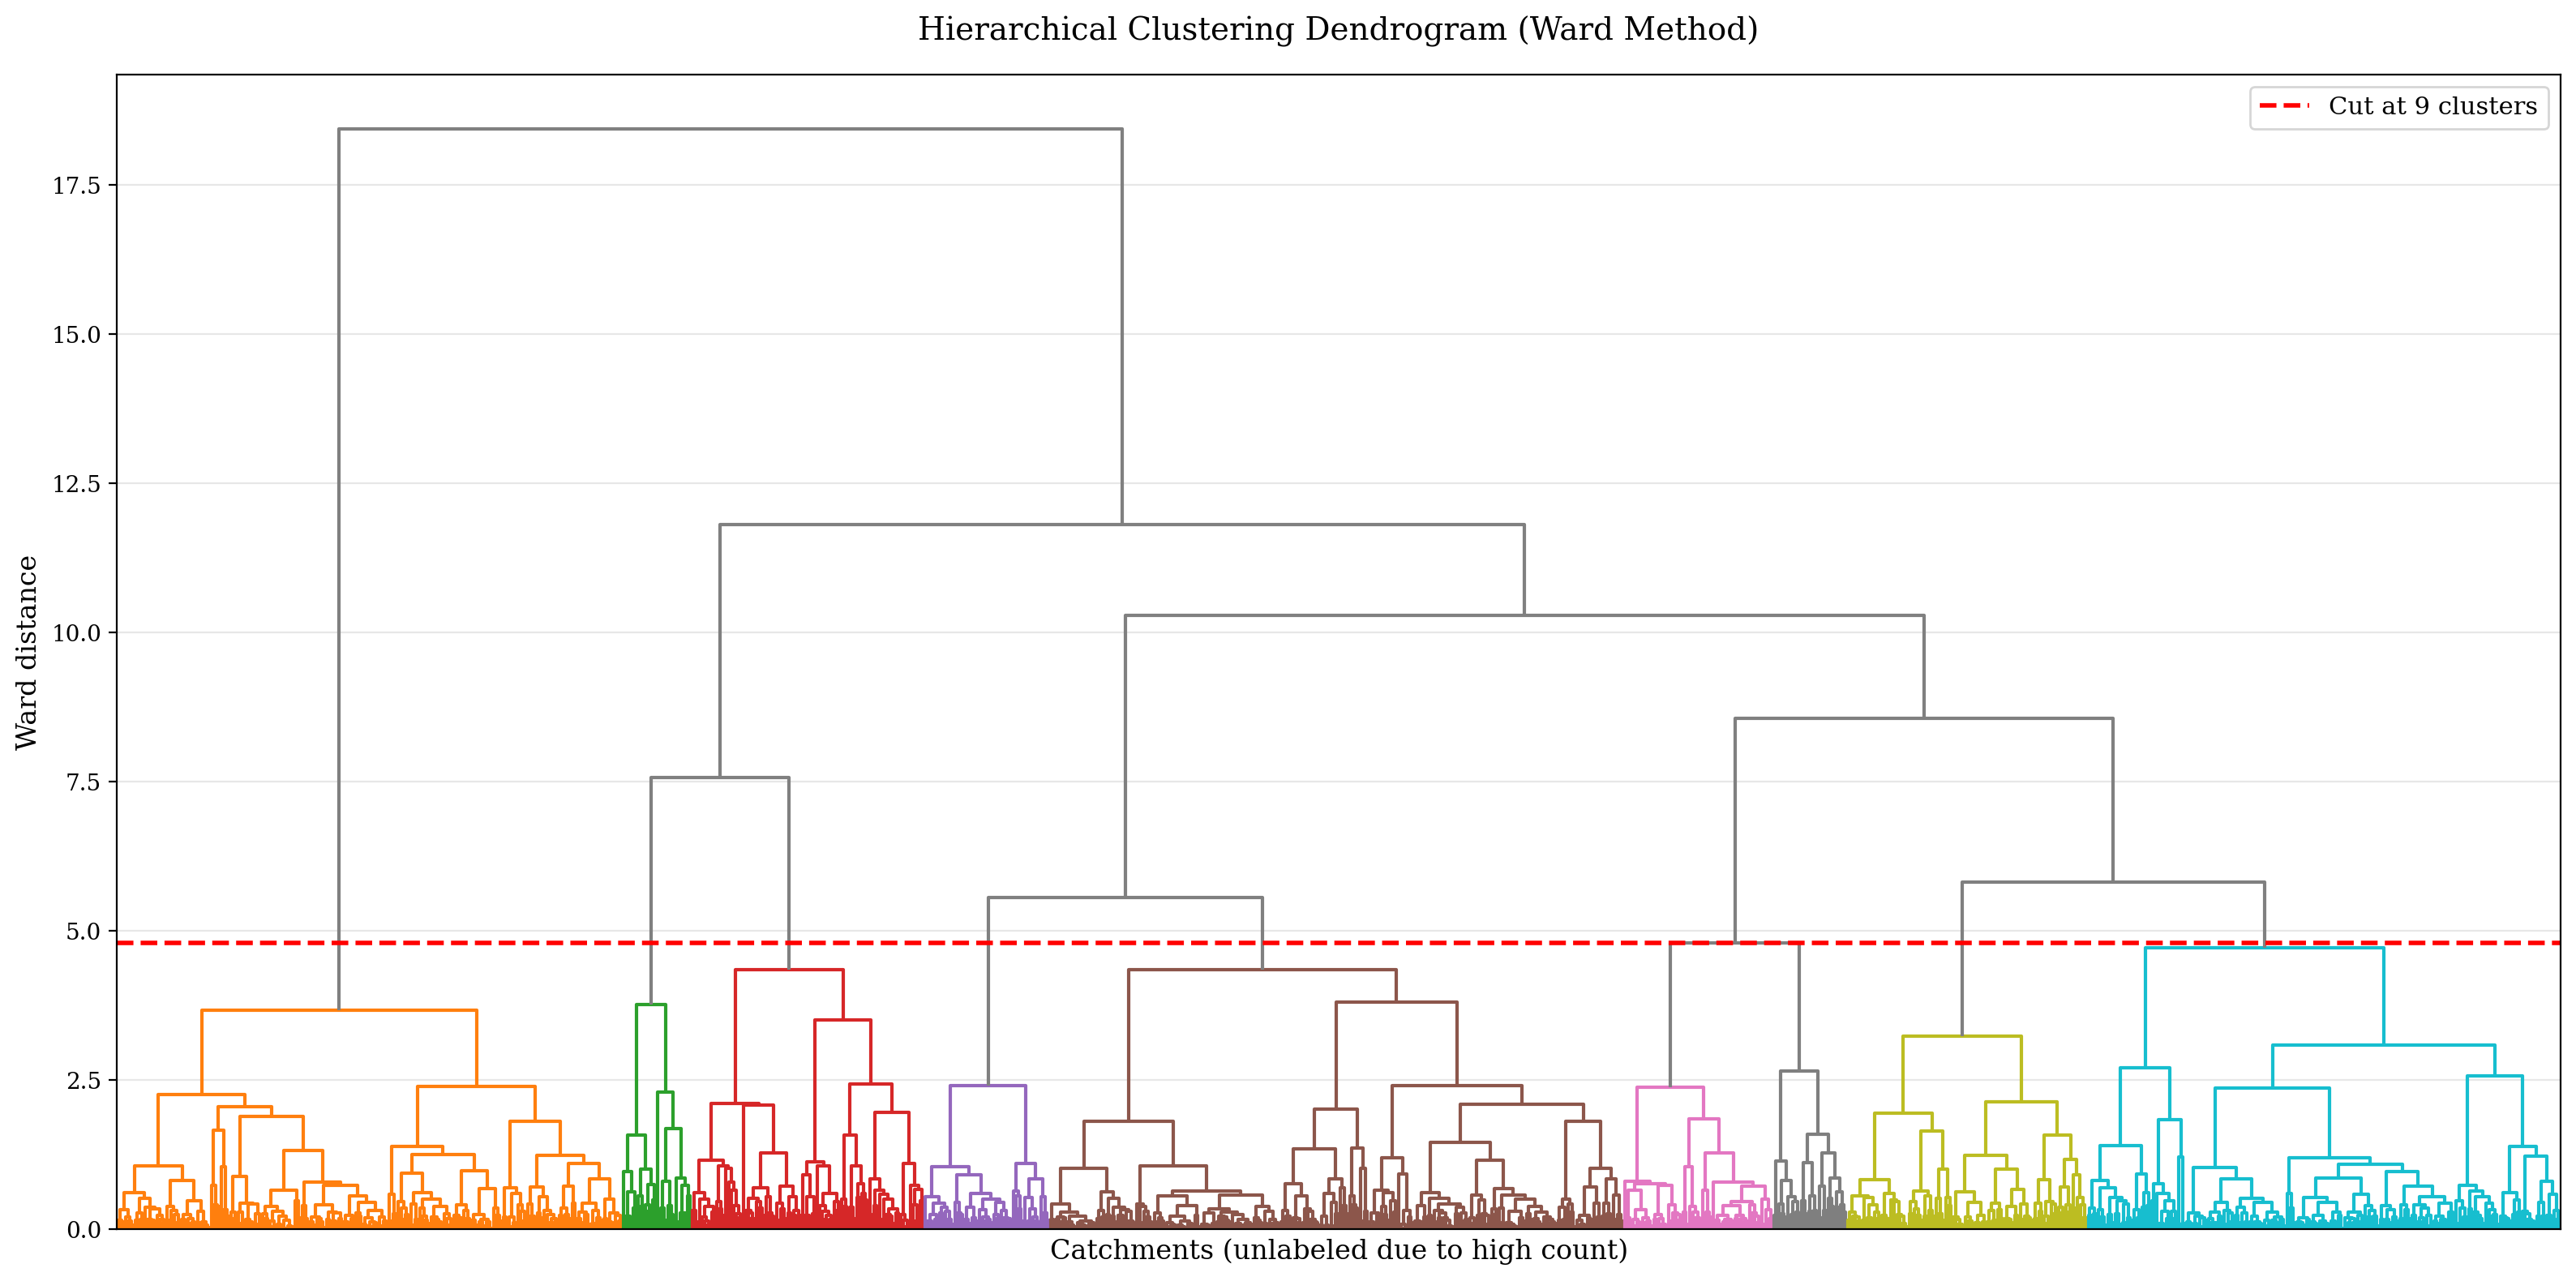

In [5]:
cluster_number = 9
# Compute linkage matrix
Z = linkage(geo_scaled.values, method="ward", metric="euclidean")

# Plot dendrogram (without x-axis labels due to many gauges)
fig, ax = plt.subplots(figsize=(16, 8))
dendro = dendrogram(
    Z,
    ax=ax,
    above_threshold_color="#808080",
    color_threshold=Z[-cluster_number + 1, 2],
    no_labels=True,  # Don't show gauge IDs on x-axis
)

ax.set_xlabel("Catchments (unlabeled due to high count)", fontsize=12)
ax.set_ylabel("Ward distance", fontsize=12)
ax.set_title("Hierarchical Clustering Dendrogram (Ward Method)", fontsize=14, pad=15)
ax.axhline(
    y=Z[-cluster_number + 1, 2],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Cut at {cluster_number} clusters",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

fig.savefig(
    f"../res/images/geo_dendrogram_ward_{cluster_number}_clusters.png",
    dpi=300,
    bbox_inches="tight",
)
plt.tight_layout()
plt.show()


In [6]:
hierarchical_labels = fcluster(Z, t=cluster_number, criterion="maxclust")

# Add to dataframes
geo_scaled["Cluster_HC"] = hierarchical_labels
gauges["Cluster_HC"] = hierarchical_labels

# Compute cluster centroids (0-1 normalized values)
cluster_centroids = geo_scaled.groupby("Cluster_HC")[available_features].mean()

# Compute raw (original scale) centroids for interpretation
geo_subset["Cluster_HC"] = hierarchical_labels
cluster_centroids_raw = geo_subset.groupby("Cluster_HC")[available_features].mean()


# CRITICAL: Use only feature columns, exclude Cluster_HC
scaled_values = geo_scaled[available_features].values
silhouette_avg = silhouette_score(scaled_values, hierarchical_labels)
silhouette_vals = silhouette_samples(scaled_values, hierarchical_labels)

ch_score = calinski_harabasz_score(scaled_values, hierarchical_labels)
db_score = davies_bouldin_score(scaled_values, hierarchical_labels)

print(f"Clustering validation metrics (k={cluster_number}):")
print(f"  Silhouette Score: {silhouette_avg:.3f}")
print(f"  Calinski-Harabasz: {ch_score:.1f}")
print(f"  Davies-Bouldin: {db_score:.3f}")

# Per-cluster silhouette
for cluster_id in range(1, cluster_number + 1):
    cluster_mask = hierarchical_labels == cluster_id
    cluster_sil = silhouette_vals[cluster_mask].mean()
    n_samples = cluster_mask.sum()
    print(f"  Cluster {cluster_id}: silhouette={cluster_sil:.3f}, n={n_samples}")

Clustering validation metrics (k=9):
  Silhouette Score: 0.243
  Calinski-Harabasz: 225.1
  Davies-Bouldin: 1.420
  Cluster 1: silhouette=0.450, n=206
  Cluster 2: silhouette=0.277, n=28
  Cluster 3: silhouette=0.112, n=95
  Cluster 4: silhouette=0.383, n=51
  Cluster 5: silhouette=0.177, n=234
  Cluster 6: silhouette=0.454, n=61
  Cluster 7: silhouette=0.157, n=30
  Cluster 8: silhouette=0.130, n=98
  Cluster 9: silhouette=0.128, n=193


Variance explained by principal components:
  PC1: 36.50% (cumulative: 36.50%)
  PC2: 19.89% (cumulative: 56.39%)
  PC3: 14.53% (cumulative: 70.92%)
  PC4: 7.76% (cumulative: 78.68%)
  PC5: 6.41% (cumulative: 85.09%)


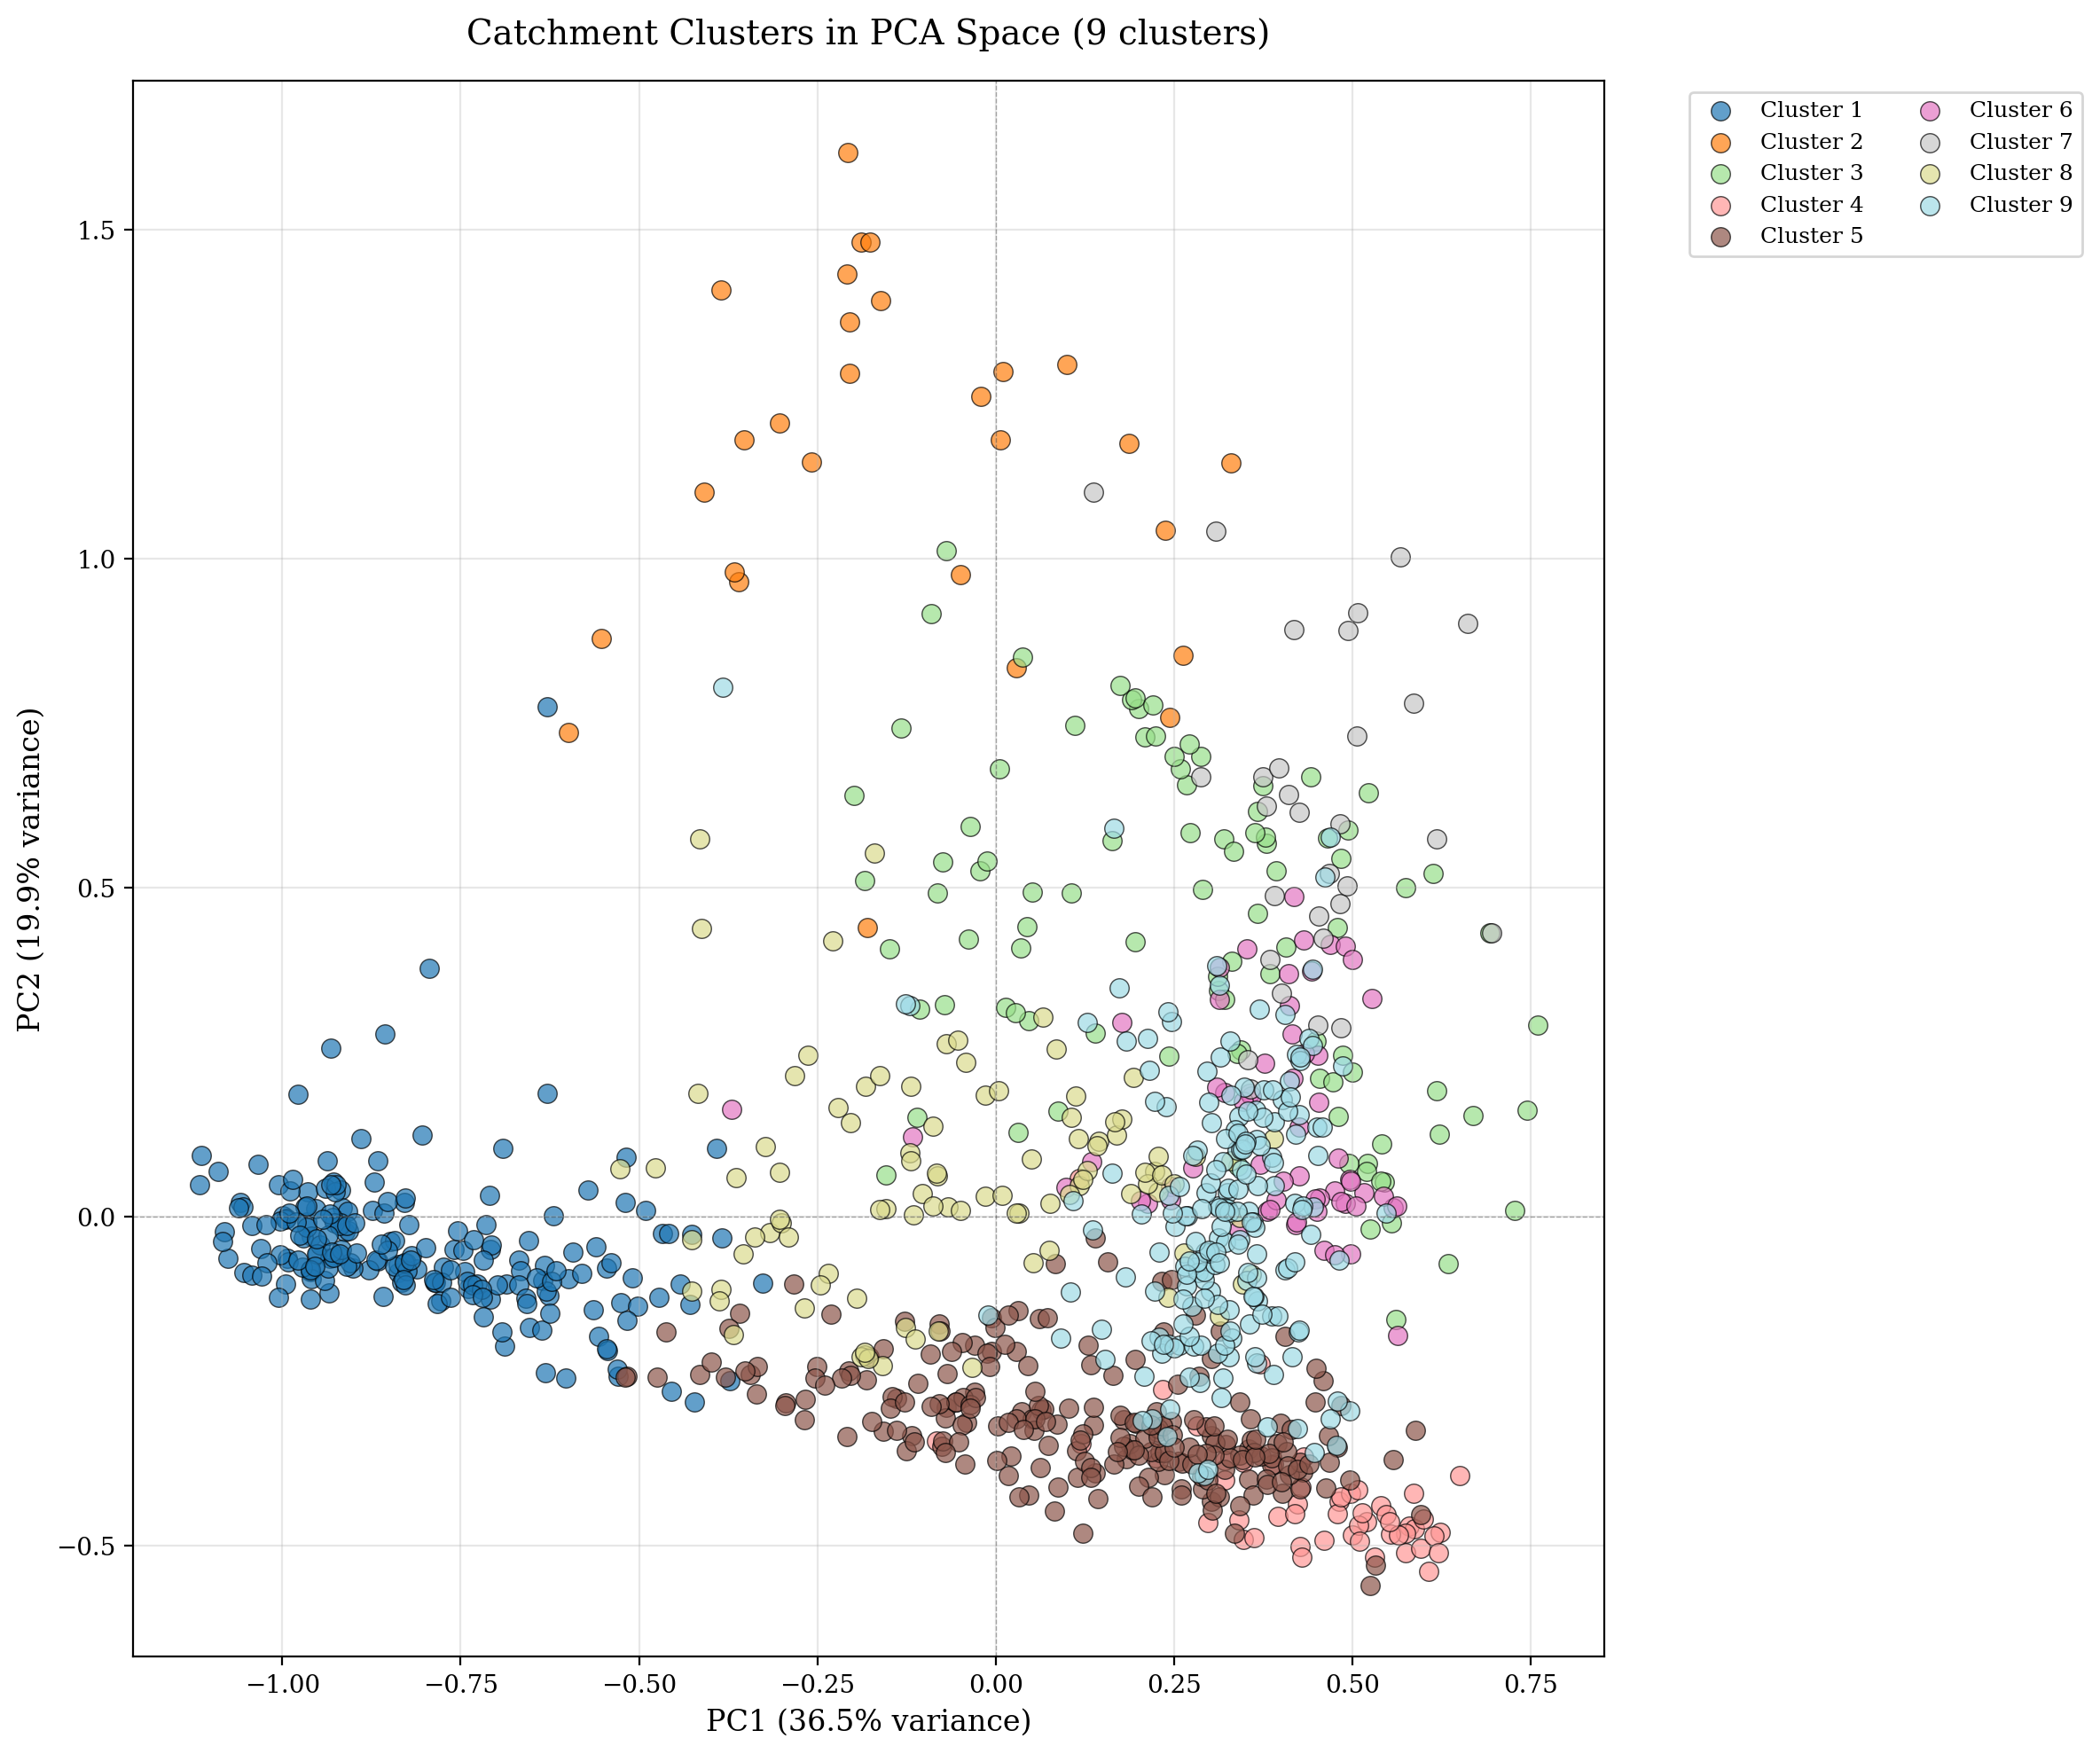

In [7]:
# Perform PCA on feature columns only (exclude Cluster_HC)
pca = PCA(n_components=min(10, len(available_features)))
pca_features = pca.fit_transform(scaled_values)

pca_df = pd.DataFrame(
    pca_features,
    columns=[f"PC{i + 1}" for i in range(pca.n_components_)],
    index=geo_scaled.index,
)
pca_df["Cluster_HC"] = hierarchical_labels

variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Print variance explained by first few components
print("Variance explained by principal components:")
for i in range(min(5, pca.n_components_)):
    print(
        f"  PC{i + 1}: {variance_explained[i] * 100:.2f}% (cumulative: {cumulative_variance[i] * 100:.2f}%)"
    )

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
cmap = plt.get_cmap("tab20", cluster_number)
colors_pca = [cmap(i) for i in range(cluster_number)]

for cluster_id in range(1, cluster_number + 1):
    cluster_mask = pca_df["Cluster_HC"] == cluster_id
    cluster_data = pca_df[cluster_mask]

    ax.scatter(
        cluster_data["PC1"],
        cluster_data["PC2"],
        c=[colors_pca[cluster_id - 1]],
        label=f"Cluster {cluster_id}",
        s=60,
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5,
    )

ax.set_xlabel(f"PC1 ({variance_explained[0] * 100:.1f}% variance)", fontsize=12)
ax.set_ylabel(f"PC2 ({variance_explained[1] * 100:.1f}% variance)", fontsize=12)
ax.set_title(
    f"Catchment Clusters in PCA Space ({cluster_number} clusters)", fontsize=14, pad=15
)
ax.axhline(y=0, color="k", linestyle="--", linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color="k", linestyle="--", linewidth=0.5, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

fig.savefig(
    f"../res/images/geo_pca_{cluster_number}_clusters.png", dpi=300, bbox_inches="tight"
)
plt.tight_layout()
plt.show()


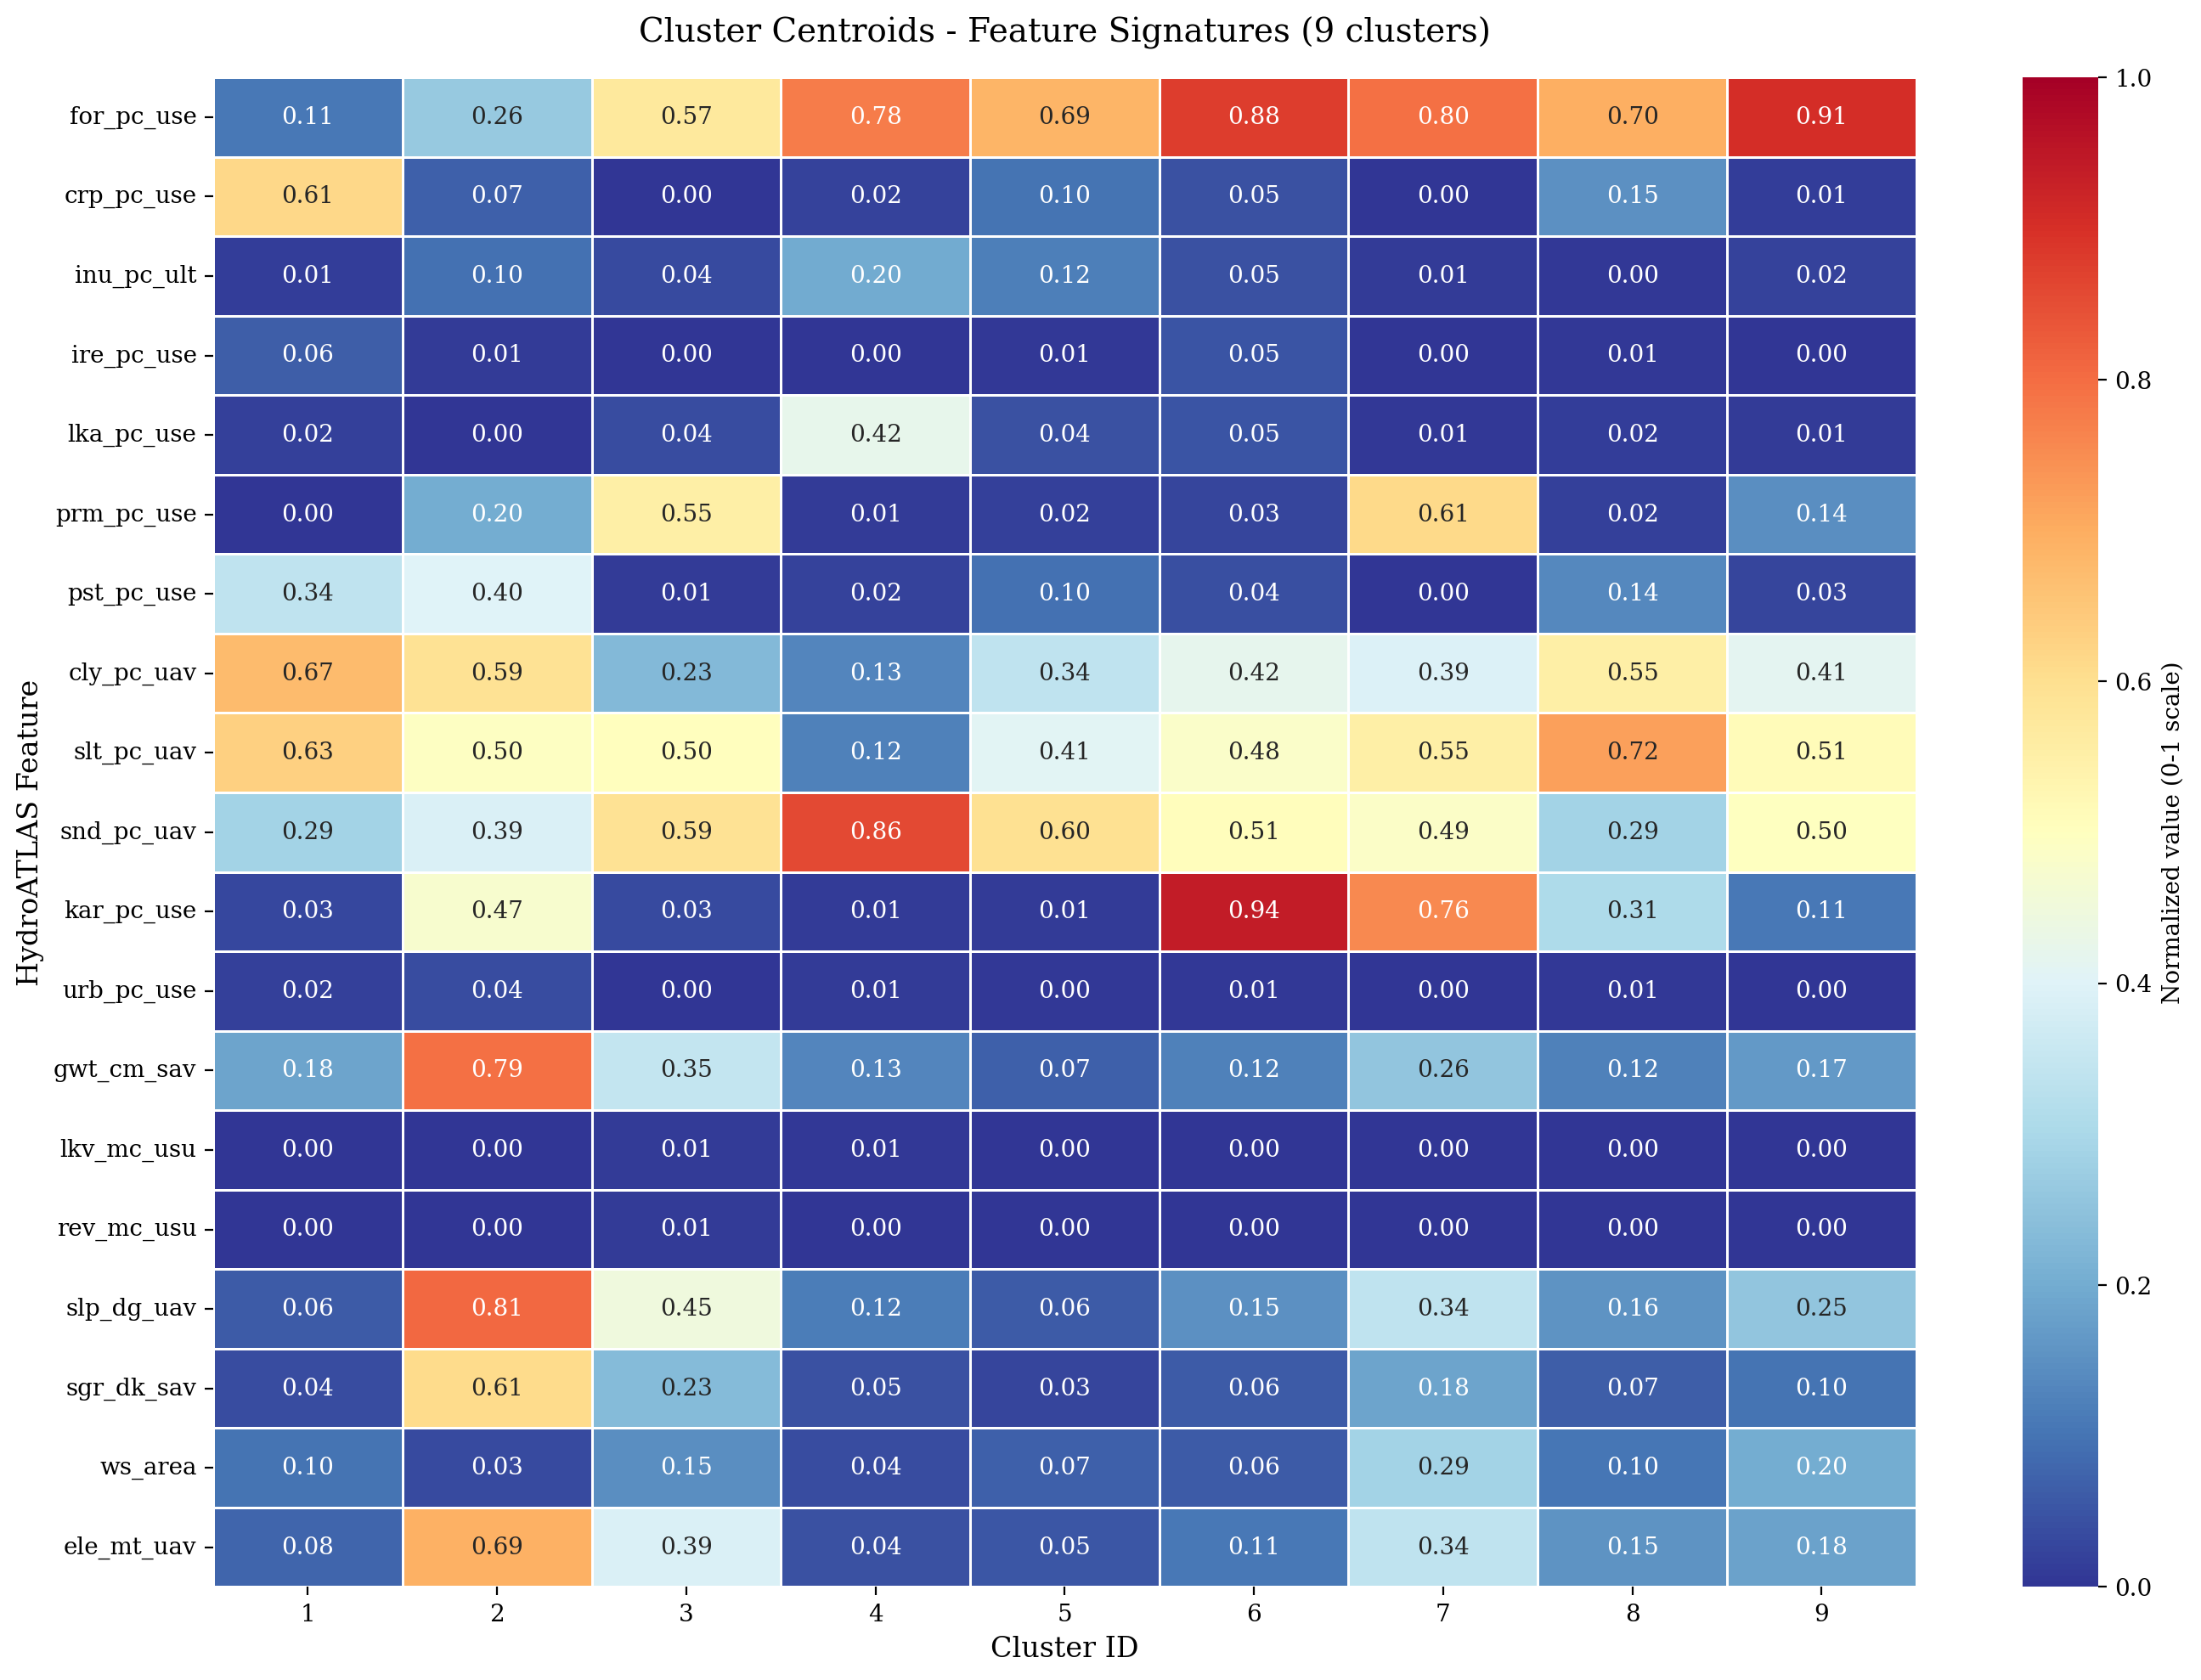

In [8]:
# Plot heatmap with 0-1 normalized values
fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(
    cluster_centroids.T,
    cmap="RdYlBu_r",
    center=0.5,
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Normalized value (0-1 scale)"},
    linewidths=0.5,
    ax=ax,
)

ax.set_xlabel("Cluster ID", fontsize=12)
ax.set_ylabel("HydroATLAS Feature", fontsize=12)
ax.set_title(
    f"Cluster Centroids - Feature Signatures ({cluster_number} clusters)",
    fontsize=14,
    pad=15,
)

fig.savefig(
    f"../res/images/geo_cluster_heatmap_{cluster_number}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.tight_layout()
plt.show()


In [9]:
# Export cluster assignments
output_path = Path(f"../res/tables/geo_catchment_clusters_{cluster_number}_final.csv")
export_df = pd.DataFrame(
    {
        "gauge_id": geo_scaled.index,
        "cluster_id": hierarchical_labels,
        "cluster_name": [f"Cluster {cl}" for cl in hierarchical_labels],
        "silhouette_score": silhouette_vals,
    }
)
export_df.to_csv(output_path, index=False)

# Export cluster centroids (both normalized and raw)
centroids_path_norm = Path(
    f"../res/tables/geo_cluster_centroids_{cluster_number}_normalized.csv"
)
centroids_path_raw = Path(f"../res/tables/geo_cluster_centroids_{cluster_number}_raw.csv")

cluster_centroids.to_csv(centroids_path_norm)
cluster_centroids_raw.to_csv(centroids_path_raw)

print(f"Exported cluster assignments to: {output_path}")
print(f"Exported normalized centroids to: {centroids_path_norm}")
print(f"Exported raw centroids to: {centroids_path_raw}")

log.info(f"Analysis complete: {cluster_number} clusters identified")


2025-10-21 00:26:01 | INFO     | PhDLogger | chapter_one | ℹ️  Analysis complete: 9 clusters identified


Exported cluster assignments to: ../res/tables/geo_catchment_clusters_9_final.csv
Exported normalized centroids to: ../res/tables/geo_cluster_centroids_9_normalized.csv
Exported raw centroids to: ../res/tables/geo_cluster_centroids_9_raw.csv


Generated cluster names:
  Cluster 1 (n=206): Clay-rich
  Cluster 2 (n=28): Deep GW (721cm) / Highland
  Cluster 3 (n=95): Mid-elevation (1166m) / Semi-arid (0mm/yr)
  Cluster 4 (n=51): Forested (77.0%) / Sandy
  Cluster 5 (n=234): Forested (68.2%)
  Cluster 6 (n=61): Forested (87.0%) / Karst
  Cluster 7 (n=30): Forested (79.0%) / Karst
  Cluster 8 (n=98): Forested (69.4%) / Silty
  Cluster 9 (n=193): Forested (90.0%)


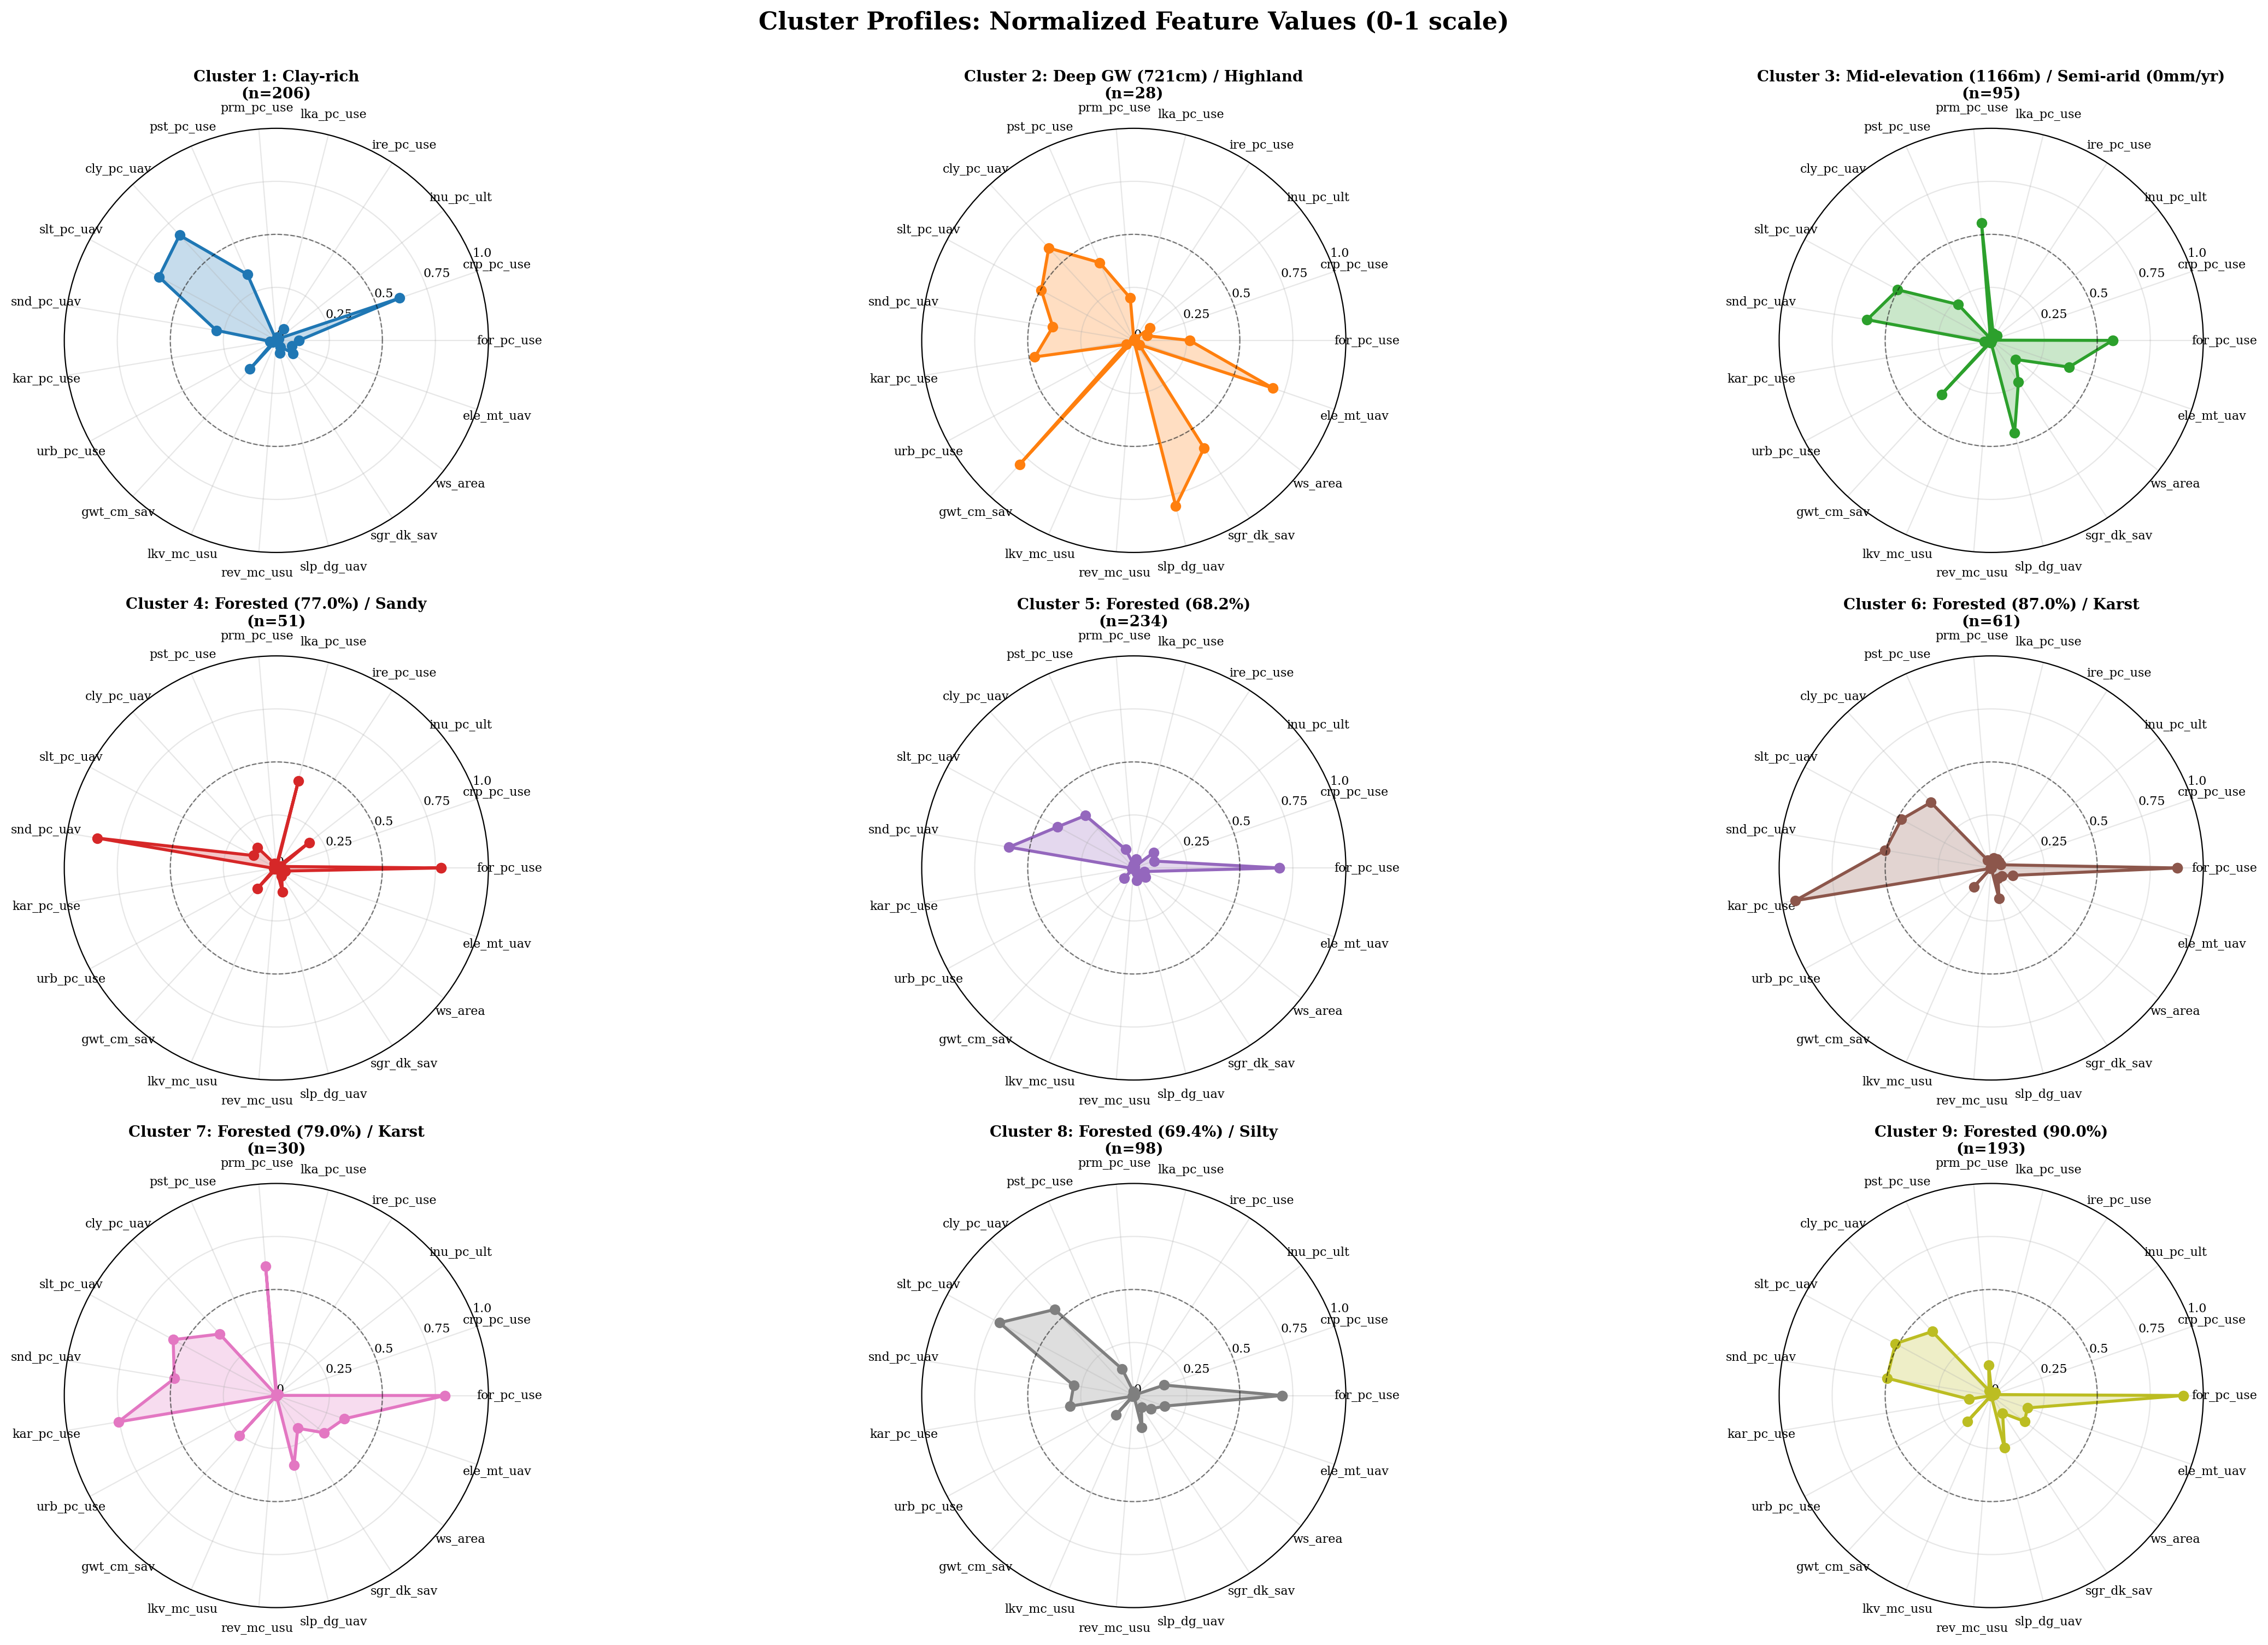


Color/Marker mapping verification:
  Cluster 1: uses color index 0 (color: #1f77b4)
  Cluster 2: uses color index 1 (color: #ff7f0e)
  Cluster 3: uses color index 2 (color: #2ca02c)
  Cluster 4: uses color index 3 (color: #d62728)
  Cluster 5: uses color index 4 (color: #9467bd)
  Cluster 6: uses color index 5 (color: #8c564b)
  Cluster 7: uses color index 6 (color: #e377c2)
  Cluster 8: uses color index 7 (color: #7f7f7f)
  Cluster 9: uses color index 8 (color: #bcbd22)


In [10]:
# Get markers and colors for clusters
markers_hc = get_cluster_markers(cluster_number)
colors_hc = get_cluster_colors(cluster_number)
marker_corrections = get_marker_size_corrections()

# Compute cluster centroids (0-1 normalized values)
cluster_centroids = geo_scaled.groupby("Cluster_HC")[available_features].mean()

# Also compute raw centroids for interpretation
cluster_centroids_raw = geo_subset.groupby("Cluster_HC")[available_features].mean()

# Generate cluster names using both normalized and raw values
cluster_names = pd.Series(index=range(1, cluster_number + 1), dtype=str)
for cluster_id in range(1, cluster_number + 1):
    normalized_row = cluster_centroids.loc[cluster_id, :]
    raw_row = cluster_centroids_raw.loc[cluster_id, :]
    cluster_names[cluster_id] = interpret_cluster_from_data(
        normalized_row, raw_row, feature_descriptions
    )

cluster_names.index.name = "Cluster"

print("Generated cluster names:")
for cid, name in cluster_names.items():
    n_catch = (hierarchical_labels == cid).sum()
    print(f"  Cluster {cid} (n={n_catch}): {name}")

# Create display names with cluster ID prefix for map legend
cluster_display_names = pd.Series(index=range(1, cluster_number + 1), dtype=str)
for cid in range(1, cluster_number + 1):
    cluster_display_names[cid] = f"C{cid}: {cluster_names[cid]}"

# Create radar charts for each cluster
n_features_display = len(available_features)
angles = np.linspace(0, 2 * np.pi, n_features_display, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Setup subplot grid
n_cols = 3
n_rows = int(np.ceil(cluster_number / n_cols))
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(25, n_rows * 5),
    subplot_kw={"projection": "polar"},
)
axes = axes.flatten() if cluster_number > 1 else [axes]

for idx, cluster_id in enumerate(range(1, cluster_number + 1)):
    ax = axes[idx]

    # Get centroid values (0-1 normalized)
    values = cluster_centroids.loc[cluster_id, available_features].tolist()
    values += values[:1]  # Complete the circle

    # Use cluster_id - 1 to index colors (ensures Cluster 1 uses colors_hc[0])
    color_idx = cluster_id - 1

    # Plot
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        color=colors_hc[color_idx],
        label=cluster_names[cluster_id],
    )
    ax.fill(angles, values, alpha=0.25, color=colors_hc[color_idx])

    # Styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(available_features, size=8)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0", "0.25", "0.5", "0.75", "1.0"], size=8)
    ax.grid(True, alpha=0.3)

    # Title with cluster size and name
    n_catchments = (hierarchical_labels == cluster_id).sum()
    ax.set_title(
        f"Cluster {cluster_id}: {cluster_names[cluster_id]}\n(n={n_catchments})",
        size=10,
        weight="bold",
        pad=20,
    )

    # Add median line (0.5)
    ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.8, alpha=0.5)

# Remove empty subplots
for idx in range(cluster_number, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle(
    "Cluster Profiles: Normalized Feature Values (0-1 scale)",
    fontsize=16,
    y=1.00,
    weight="bold",
)
plt.tight_layout()
fig.savefig(
    f"../res/images/geo_cluster_radar_{cluster_number}_profiles.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("\nColor/Marker mapping verification:")
for cid in range(1, cluster_number + 1):
    color_idx = cid - 1
    print(
        f"  Cluster {cid}: uses color index {color_idx} (color: {colors_hc[color_idx]})"
    )


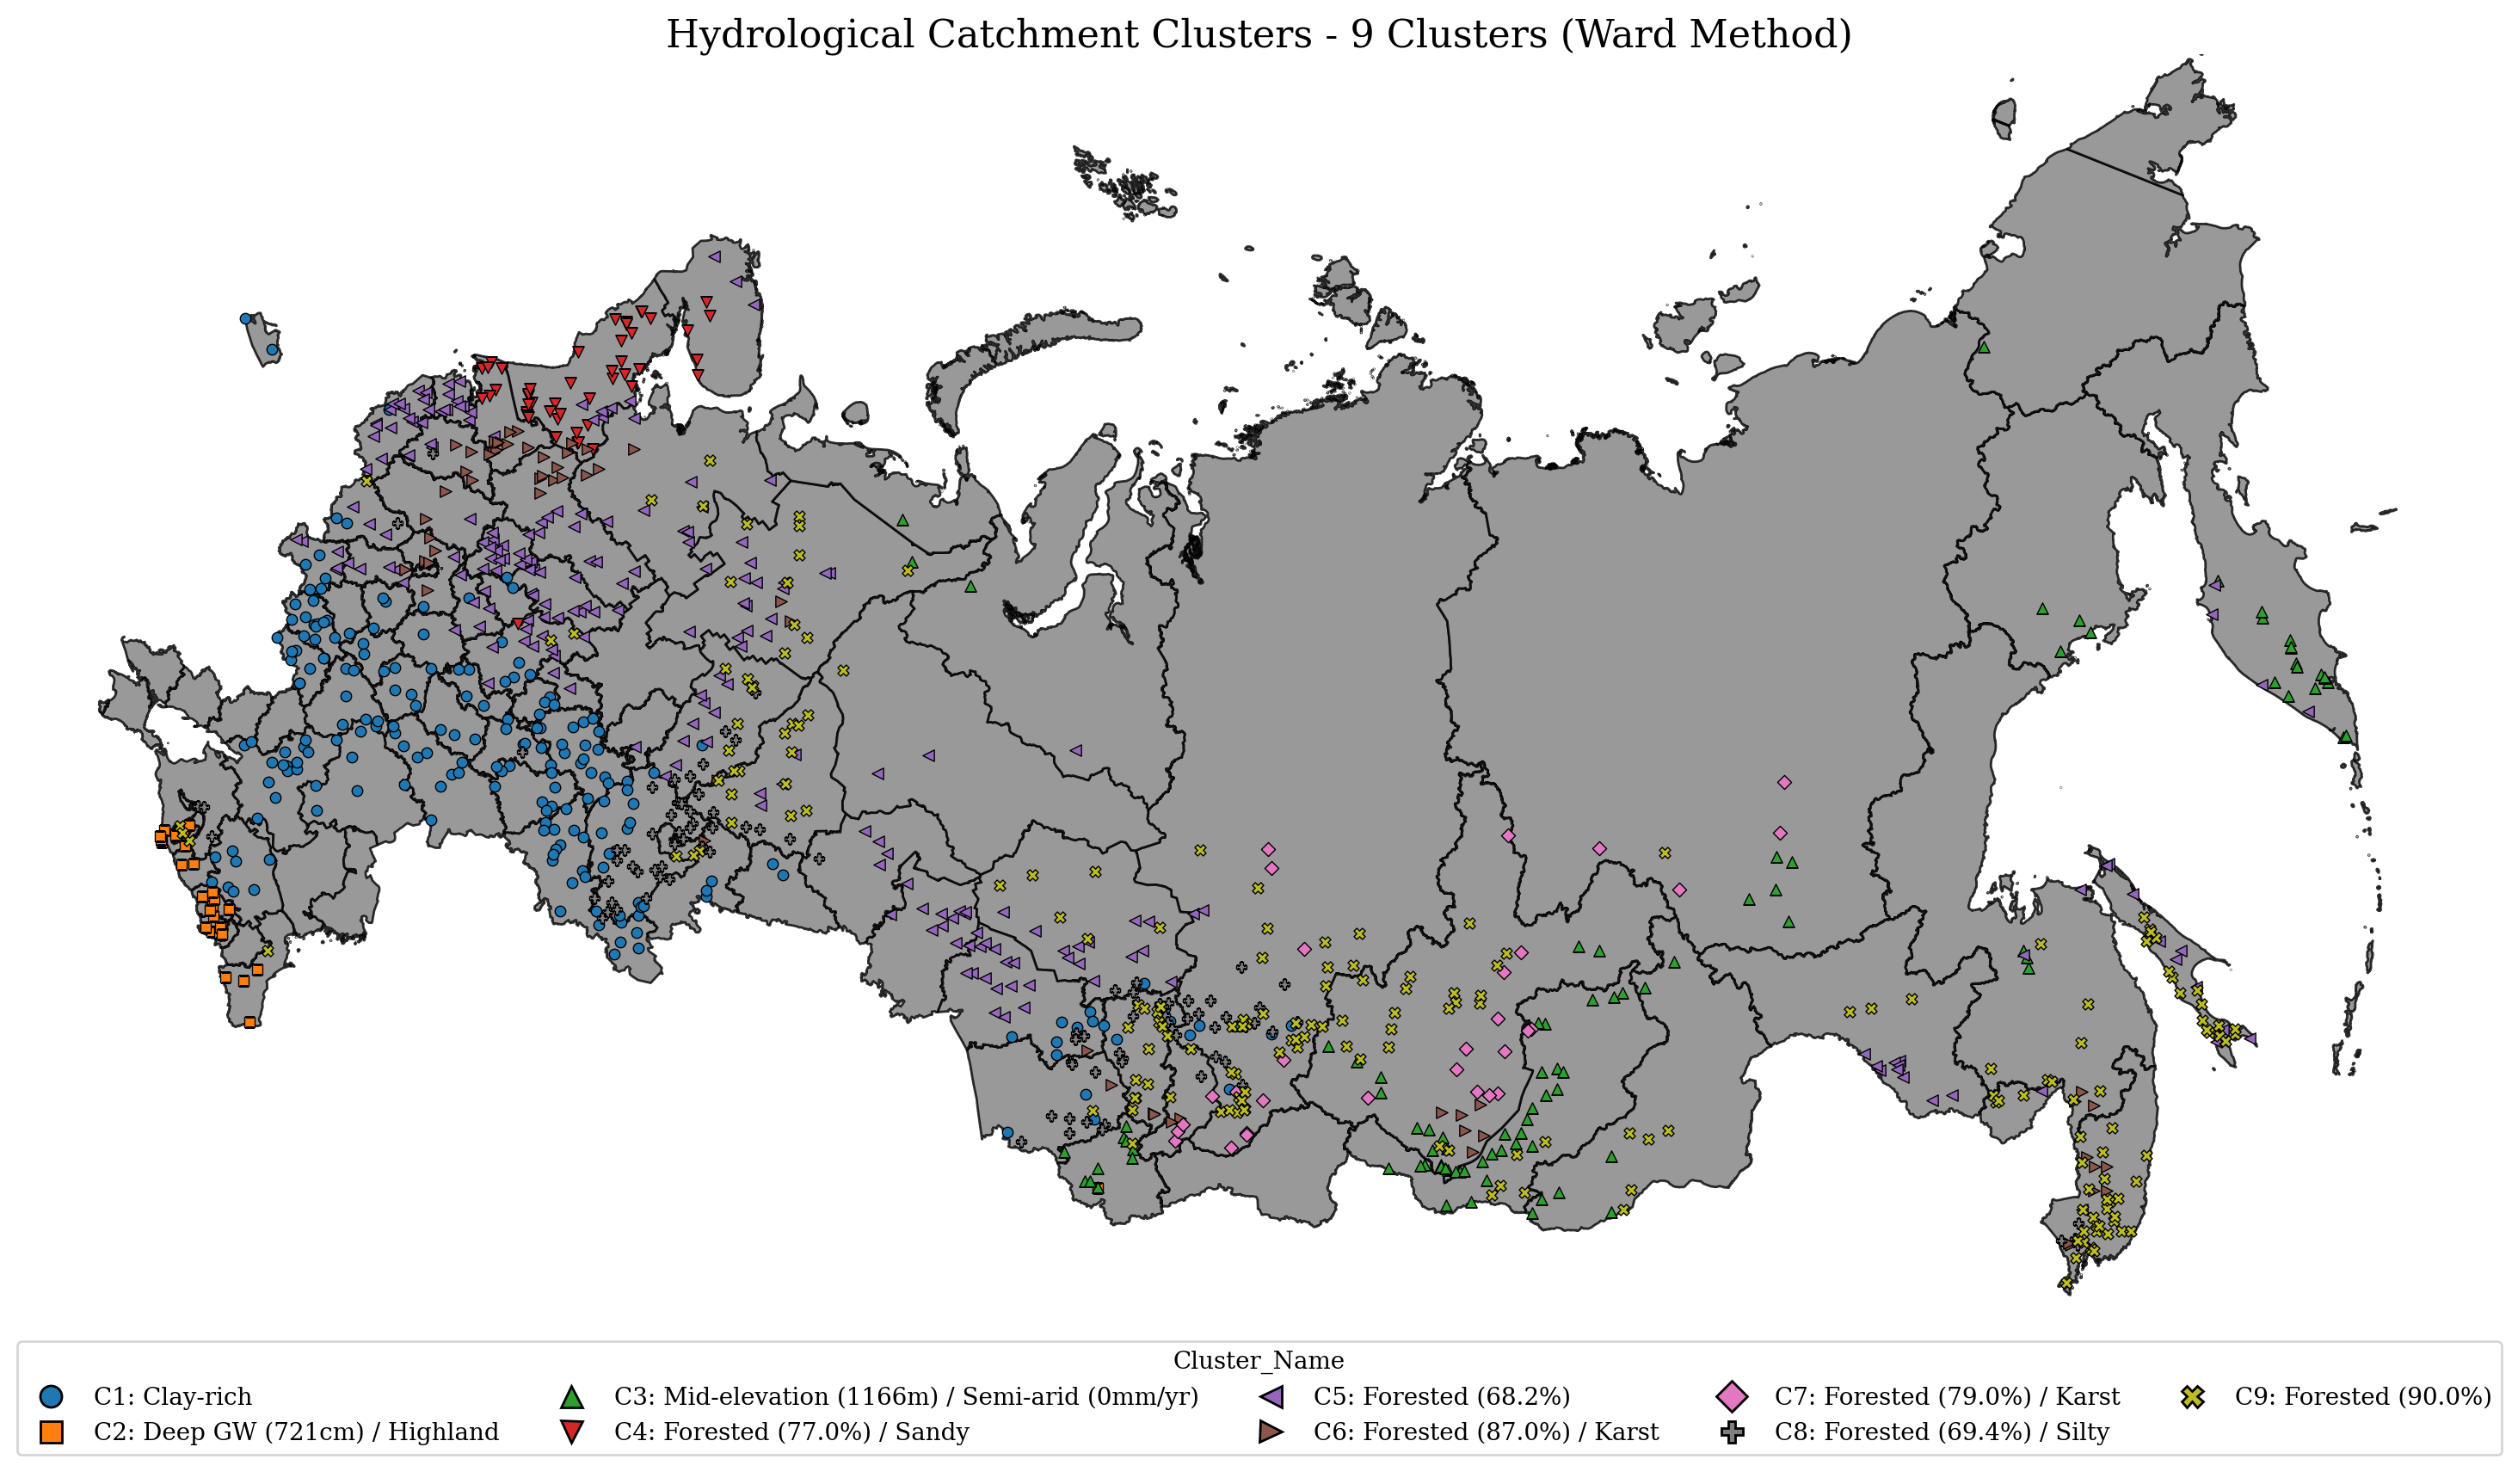

In [ ]:
# Prepare cluster names for geographic visualization
gauge_clustered = gauges.copy()
# Use display names with "C{id}:" prefix so sorting works correctly
gauge_clustered["Cluster_Name"] = [
    cluster_display_names[cl] for cl in hierarchical_labels
]

# Plot map with proper cluster names
fig_clusters_map = russia_plots(
    gdf_to_plot=gauge_clustered,
    basemap_data=basemap_data,
    distinction_col="Cluster_Name",
    markers_list=markers_hc,
    color_list=colors_hc,
    marker_size_corrections=marker_corrections,
    figsize=(16, 9),
    just_points=True,
    legend_cols=5,
    base_marker_size=20,
    base_linewidth=0.5,
)

fig_clusters_map.suptitle(
    f"Hydrological Catchment Clusters - {cluster_number} Clusters (Ward Method)",
    fontsize=16,
    y=0.98,
)
fig_clusters_map.savefig(
    f"../res/images/geo_hierarchical_{cluster_number}clusters_map.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
